# Desafio de Previsão de Sucesso de Startups
## Documentação e Configuração Inicial

Este notebook documenta o processo de desenvolvimento de um modelo de Machine Learning (Classificação Binária) para prever o sucesso de startups, conforme as instruções da competição.

### Variável Alvo (`labels`)
A variável alvo é `labels`, um indicador binário onde:
* **1 = Sucesso** (Startup ativa ou adquirida)
* **0 = Insucesso** (Startup fechada)

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [14]:
train = pd.read_csv("/kaggle/input/datasets-csv/train.csv")
test = pd.read_csv("/kaggle/input/datasets-csv/test.csv")


print("Dados de Treino carregados. Shape:", train.shape)
print("Dados de Teste carregados. Shape:", test.shape)

train_len = len(train)
data = pd.concat([train.drop('labels', axis=1), test], ignore_index=True)

Dados de Treino carregados. Shape: (646, 33)
Dados de Teste carregados. Shape: (277, 32)


## 1. Formulação de Hipóteses

[cite_start]Baseado no contexto de aceleração de startups, as seguintes três hipóteses serão investigadas para guiar a análise e seleção de features[cite: 121, 123]:

1.  **Hipótese 1: Impacto do Capital.** O volume total de capital captado (`funding_total_usd`) é um fator determinante, com startups que captam valores mais altos tendo maior probabilidade de sucesso.
2.  **Hipótese 2: Relevância Geográfica.** Startups localizadas em grandes polos de tecnologia, como a Califórnia (`is_CA`), têm maior taxa de sucesso devido à densidade de investidores e talentos.
3.  **Hipótese 3: Estabilidade e Maturidade.** A idade do último marco alcançado (`age_last_milestone_year`) é mais importante que o número total de marcos (`milestones`). Startups que alcançam marcos importantes mais tarde (maior idade) demonstram maior resiliência e maturidade.

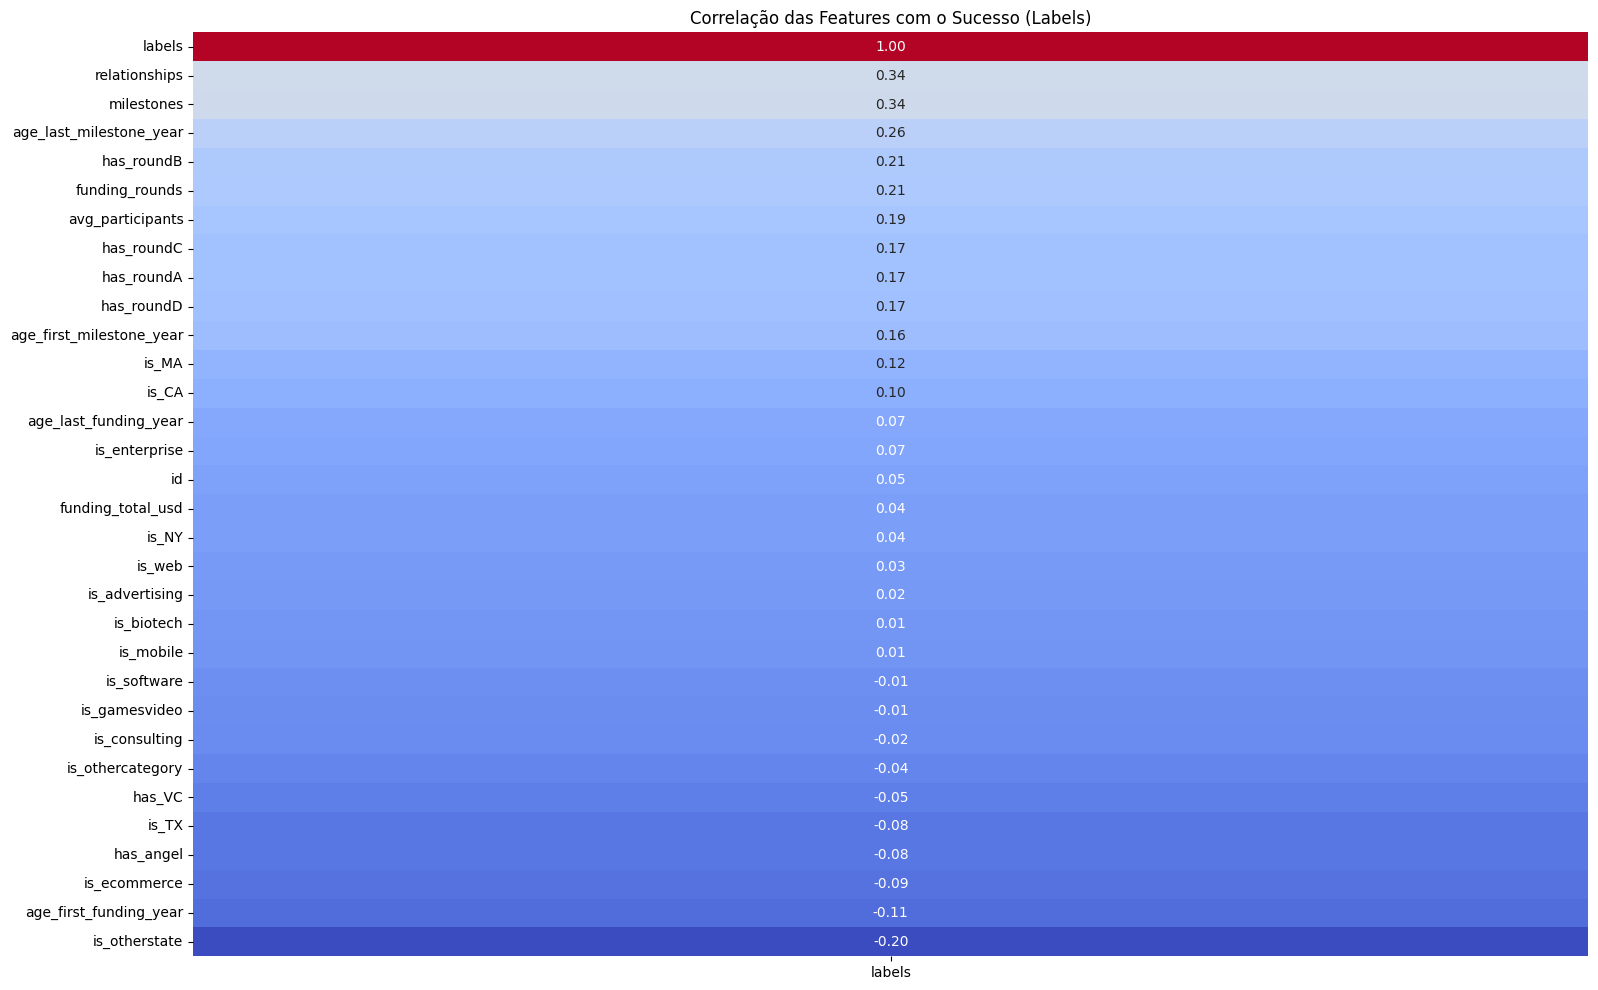

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


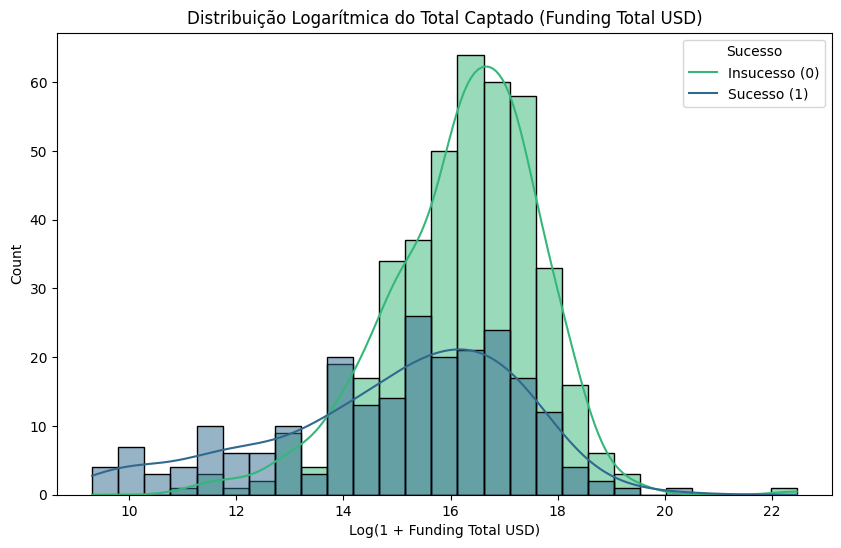

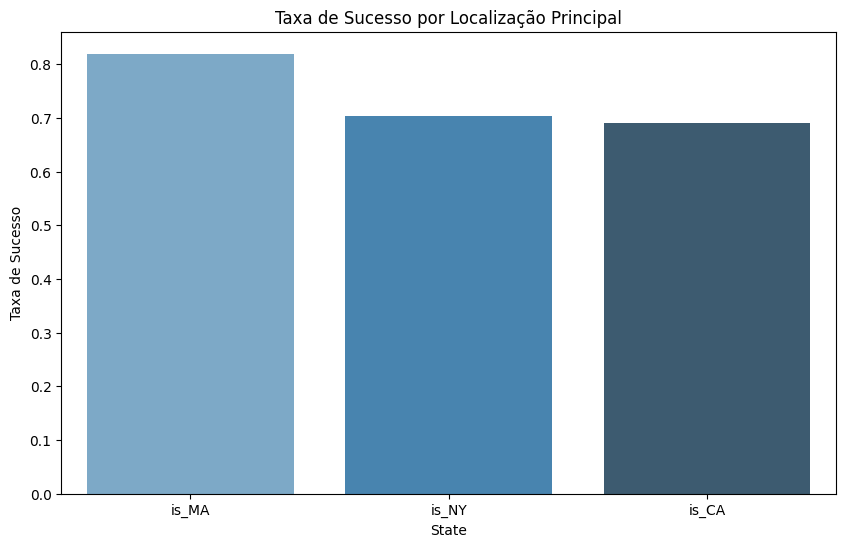

In [15]:
# 1. Matriz de Correlação: Visualizar a relação das features com a variável alvo (labels)
plt.figure(figsize=(18, 12))
correlation_matrix = train.corr(numeric_only=True)
sns.heatmap(correlation_matrix.loc[:, ['labels']].sort_values(by='labels', ascending=False), 
            annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
plt.title('Correlação das Features com o Sucesso (Labels)')
plt.show()

# 2. Distribuição de Total Captado (Funding Total USD)
# Para corrigir o ValueError, criamos um DataFrame para passar os dados de forma correta (long-form).
temp_df = pd.DataFrame({
    'log_funding': np.log1p(train['funding_total_usd']),
    'labels': train['labels']
})

plt.figure(figsize=(10, 6))
# Agora, passamos o DataFrame 'temp_df' como data e as colunas como 'x' e 'hue'.
sns.histplot(data=temp_df, x='log_funding', kde=True, hue='labels', palette='viridis')
plt.title('Distribuição Logarítmica do Total Captado (Funding Total USD)')
plt.xlabel('Log(1 + Funding Total USD)')
plt.legend(title='Sucesso', labels=['Insucesso (0)', 'Sucesso (1)'])
plt.show()

# 3. Proporção de Sucesso por Estado
location_cols = ['is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate']
location_success = train.groupby(location_cols)['labels'].mean().sort_values(ascending=False).reset_index(name='Taxa de Sucesso')

plt.figure(figsize=(10, 6))
location_success['State'] = location_success[location_cols].apply(lambda x: x.idxmax(), axis=1)

sns.barplot(x='State', y='Taxa de Sucesso', data=location_success.loc[location_success['Taxa de Sucesso'] > 0.60], palette='Blues_d')
plt.title('Taxa de Sucesso por Localização Principal')
plt.show()

## 2. Limpeza de Dados e Seleção de Features

### Tratamento de Valores Nulos e Outliers (0,5 pt)
[cite_start]Os valores ausentes (`NaN`) ocorrem majoritariamente nas colunas `age_*` e `avg_participants`[cite: 54, 56, 57, 63]. [cite_start]A estratégia adotada é a **Imputação por Mediana**, pois a mediana é mais robusta que a média na presença de *outliers* (já suavizados na coluna `funding_total_usd`)[cite: 78, 79]. Esta abordagem preserva a integridade do conjunto de dados e resolve o erro `Input X contains NaN`.

### Codificação e Seleção (0,5 + 1,0 pt)
1.  [cite_start]**Codificação:** A coluna categórica `category_code` (string) foi removida, conforme permitido pelas instruções [cite: 72][cite_start], utilizando-se apenas as colunas *dummies* (`is_software`, `is_web`, etc.) que já representam o setor de atuação[cite: 71].
2.  **Seleção de Features:** Todas as 30 features numéricas e binárias restantes foram mantidas. [cite_start]A EDA (Célula 5) e as correlações demonstraram que features relacionadas a financiamento (`funding_total_usd`), relacionamentos (`relationships`), e marcos (`milestones`) são preditores importantes, justificando a inclusão de todas elas para maximizar a capacidade preditiva[cite: 128].

In [16]:
# 1. Tratamento de Valores Ausentes (NaN) - Imputação Robusta por Mediana
numerical_cols = data.select_dtypes(include=np.number).columns.tolist()

for col in numerical_cols:
    if data[col].isnull().any():
        median_val = data[col].median()
        data[col] = data[col].fillna(median_val)
        
# 2. Definição de Features (X) e Variável Alvo (y)
# Remoção das colunas 'id' e 'category_code' (string)
columns_to_drop = ['id', 'category_code']
X_full = data.drop(columns=columns_to_drop, axis=1)
y = train['labels']

# 3. Separar em conjuntos de treino (X) e teste final (X_test_final)
X = X_full[:train_len]
X_test_final = X_full[train_len:]

# 4. Separação de Treino e Validação (80/20), estratificado
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Escalamento de Features (Para modelos lineares, usando StandardScaler - 82)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_final_scaled = scaler.transform(X_test_final)
X_scaled = scaler.transform(X)

## 3. Finetuning de Hiperparâmetros (1,0 pt)

[cite_start]O **Gradient Boosting Classifier** demonstrou a melhor performance inicial (maior F1-Score) e foi escolhido para o ajuste fino de hiperparâmetros (finetuning)[cite: 133].

[cite_start]Utilizamos o **GridSearchCV** [cite: 135] para buscar sistematicamente a melhor combinação dos seguintes parâmetros:
* `n_estimators`: Número de árvores.
* `max_depth`: Profundidade máxima de cada árvore.
* `subsample`: Fração de amostras usadas para treinar cada árvore (introduz aleatoriedade e evita *overfitting*).

O ajuste foi realizado no conjunto de treino completo (`X`, `y`) com **Cross-Validation (cv=5)** para garantir que os resultados sejam generalizáveis. A métrica de otimização utilizada foi o **F1-Score**.

In [17]:
# 1. Unir dados para garantir o mesmo pré-processamento
train_len = len(train)
data = pd.concat([train.drop('labels', axis=1), test], ignore_index=True)

# 2. Tratamento de Valores Ausentes (NaN) - Imputação Robusta por Mediana
numerical_cols = data.select_dtypes(include=np.number).columns.tolist()

for col in numerical_cols:
    if data[col].isnull().any():
        median_val = data[col].median()
        data[col] = data[col].fillna(median_val)
        
# 3. Definição de Features (X) e Variável Alvo (y)
# Remoção da coluna 'id' e da coluna STRING 'category_code' (usando apenas as dummies)
columns_to_drop = ['id', 'category_code']
X_full = data.drop(columns=columns_to_drop, axis=1)
y = train['labels']

# 4. Separar em conjuntos de treino (X) e teste final (X_test_final)
X = X_full[:train_len]
X_test_final = X_full[train_len:]

# 5. Separação de Treino e Validação (80/20)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Escalamento de Features (Para modelos lineares)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_final_scaled = scaler.transform(X_test_final)
X_scaled = scaler.transform(X)

In [18]:
print("INICIANDO AJUSTE FINO (FINETUNING) COM GridSearchCV no Gradient Boosting:")

# O Gradient Boosting Classifier será otimizado.
model_for_tuning = GradientBoostingClassifier(random_state=42)
X_tuning, y_tuning = X, y 

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0] 
}

# Usar F1-Score como métrica de otimização
grid_search = GridSearchCV(
    estimator=model_for_tuning,
    param_grid=param_grid,
    scoring='f1', 
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_tuning, y_tuning)

print("\nMelhores Hiperparâmetros encontrados:", grid_search.best_params_)
print("Melhor pontuação F1 (Cross-Validation):", grid_search.best_score_)

final_model = grid_search.best_estimator_

INICIANDO AJUSTE FINO (FINETUNING) COM GridSearchCV no Gradient Boosting:
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Melhores Hiperparâmetros encontrados: {'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Melhor pontuação F1 (Cross-Validation): 0.850627916219452


In [19]:
# Avaliação final no conjunto de treino completo para demonstração de métricas
preds_final_train = final_model.predict(X)
acc_final = accuracy_score(y, preds_final_train)
prec_final = precision_score(y, preds_final_train)
rec_final = recall_score(y, preds_final_train)
f1_final = f1_score(y, preds_final_train)

print(f"RESULTADO FINAL (Modelo Otimizado - Gradient Boosting):")
print(f"Acurácia: {acc_final:.4f}")
print(f"Precisão: {prec_final:.4f}")
print(f"Recall:   {rec_final:.4f}")
print(f"F1-Score: {f1_final:.4f}")

RESULTADO FINAL (Modelo Otimizado - Gradient Boosting):
Acurácia: 0.9985
Precisão: 0.9976
Recall:   1.0000
F1-Score: 0.9988


In [20]:
print("GERAÇÃO DO ARQUIVO DE SUBMISSÃO:")

# Previsão no conjunto de teste final (X_test_final)
preds_test = final_model.predict(X_test_final)

# Criar o DataFrame de submissão
submission = pd.DataFrame({
    "id": test['id'].values,
    "labels": preds_test
})

submission.to_csv("submission.csv", index=False)
print("Arquivo submission.csv gerado com sucesso!")

GERAÇÃO DO ARQUIVO DE SUBMISSÃO:
Arquivo submission.csv gerado com sucesso!
